In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from clearml import Task

from sklearn import linear_model
from sklearn import preprocessing

from amplify.DataGeneration import DataGenerator

In [8]:
# Constants 
BUILDING_LAT = 39.9649 
BUILDING_LON = -75.1396 

In [9]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="power-ss-notebook")


In [10]:
# DataGenerator - ClearML
data_generator = DataGenerator()
# LoadData - ClearML
load_success, building_data, weather_data = data_generator.LoadData()


Info: Successfully loaded building data!


/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

overflow encountered in exp

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

invalid value encountered in multiply

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

overflow encountered in exp

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

invalid value encountered in multiply

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

overflow encountered in exp

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

invalid value encountered in multiply

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.p

Info: Successfully loaded weather data!


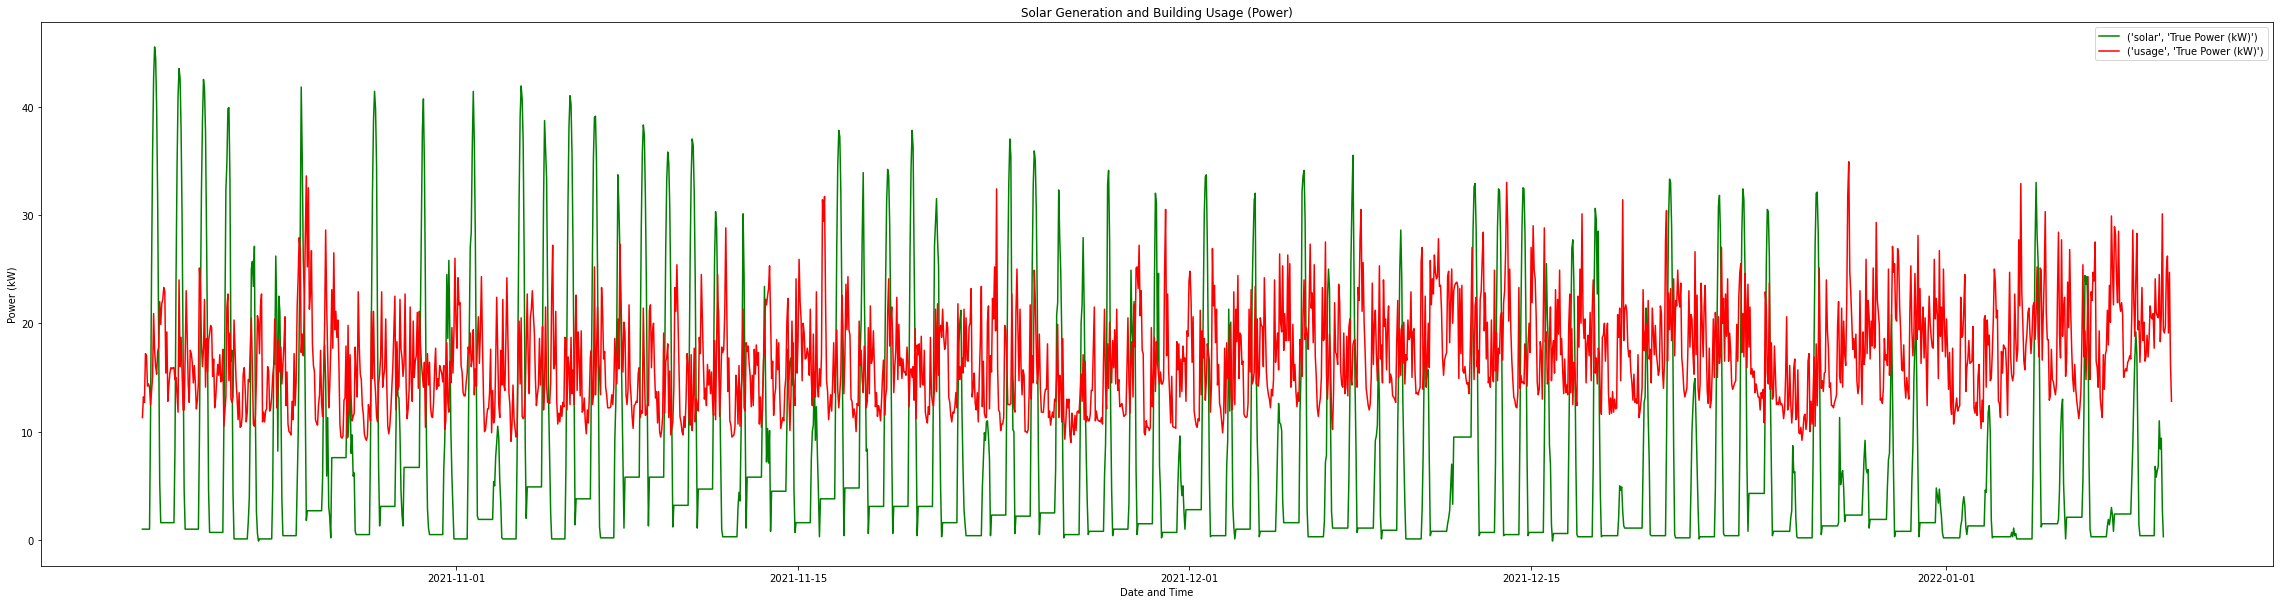

In [11]:
# Plot Power - Solar Gen vs Building Usage
fig, ax = plt.subplots(figsize=(40, 10))
plt.title("Solar Generation and Building Usage (Power)")

ax.plot(building_data.solar["True Power (kW)"], color="g")
ax.plot(building_data.usage["True Power (kW)"], color="r")

ax.set_xlabel("Date and Time")
ax.set_ylabel("Power (kW)")
plt.legend(building_data.columns)
plt.show()


/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



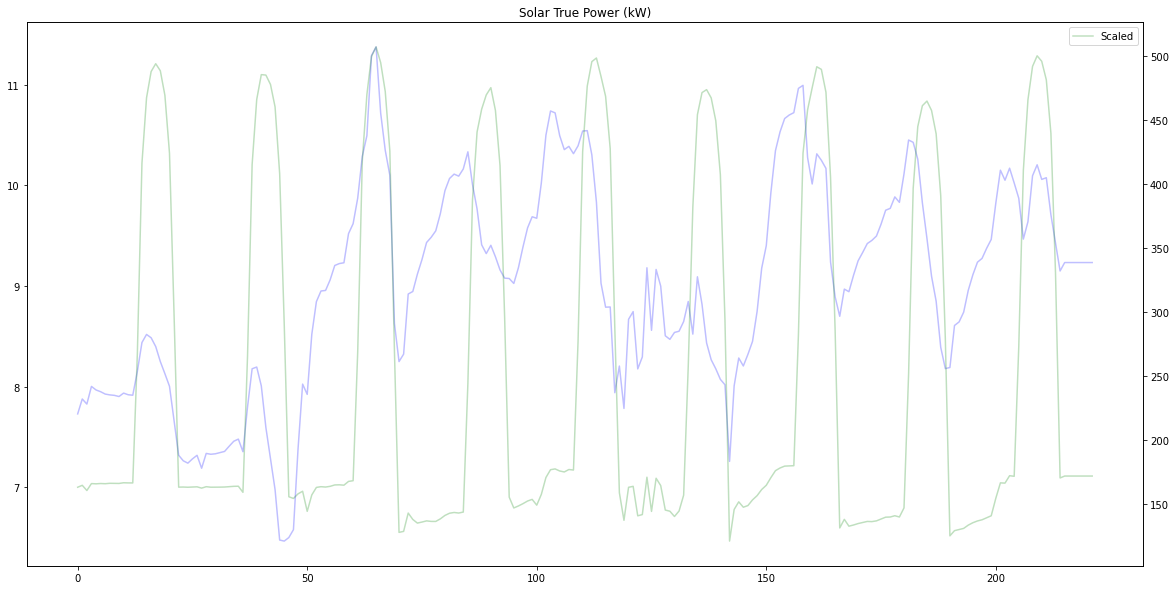

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



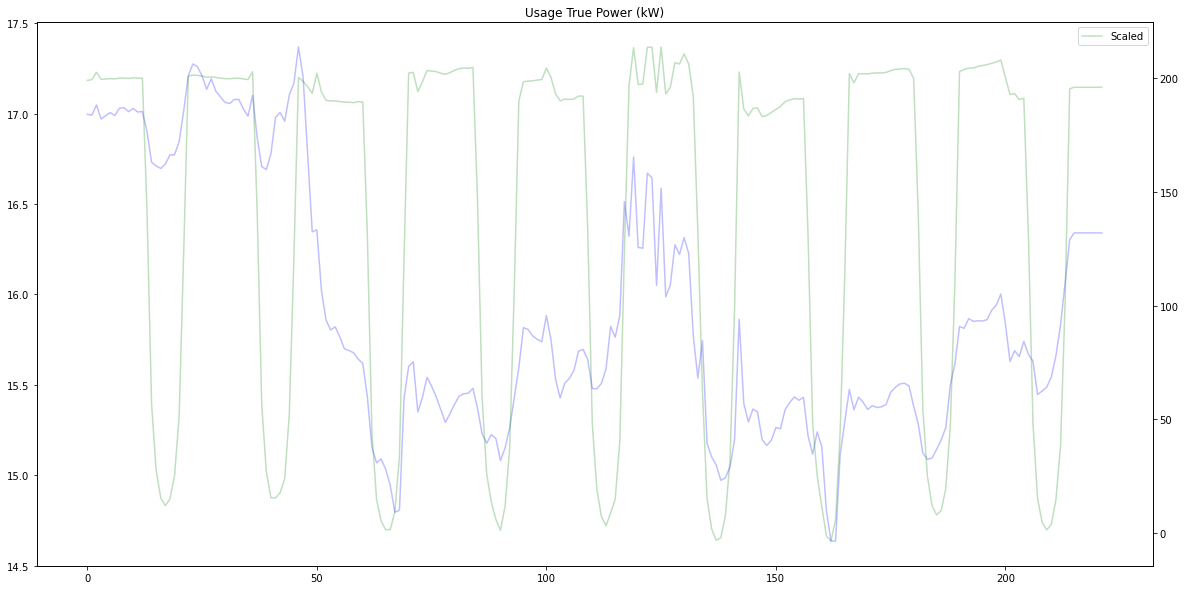

In [12]:
# Build class for EWM Linear Regression to compare scaled/non-scaled features
class Weather_EWM:
    def __init__(self, features, y, split_date, to_scale=True):
        self.data = features
        self.y = y
        self.split_date = split_date
        self.scale = to_scale

    # Reversed-Recombined EWMA for improved accuracy
    def ewm_calculator(self):

        # Create dataframe To collect data
        self.ewm_out = pd.DataFrame()

        # Calculate fwd and bwd EWMA
        self.ewm_out["fwd"] = self.y.ewm(span=24).mean()
        self.ewm_out["bwd"] = self.y[::-1].ewm(span=24).mean()

        # Reversed-Recombined EWMA
        self.ewm_out["combo"] = self.ewm_out.mean(axis=1)

        return self.ewm_out

    # Test/Train split and standardization of weather data
    def weather_prep(self):

        # Run ewma calculator
        self.ewm = self.ewm_calculator()

        # Test / Train split for Y based on chosen split_date
        self.ewm_train = self.ewm[self.ewm.index <= self.split_date]
        self.ewm_test = self.ewm[self.ewm.index > self.split_date]

        # Test/Train split for Weather data to match Y-data
        self.weather_train = self.data[: len(self.ewm_train)]
        self.weather_test = self.data[len(self.ewm_train) :]

        # Scale features in training set:
        if self.scale:
            self.weather_scaler = preprocessing.StandardScaler()
            self.weather_train = self.weather_scaler.fit_transform(self.weather_train)

        return self.weather_train, self.weather_test, self.ewm_train, self.ewm_test

    def weather_ewma(self):
        # Run train/test split based on date and scaling
        self.x_train, self.x_test, self.y_train, self.y_test = self.weather_prep()

        # On to the regression:
        self.lin_reg = linear_model.LinearRegression()
        self.lin_reg.fit(self.x_train, self.y_train.combo)

        self.ewm_solar_pred = self.lin_reg.predict(self.x_test)

        return self.ewm_solar_pred


# Set split date for Linear Regression validation
split_date = pd.to_datetime("2022-01-01", utc=True)

# Set list of y-values we want to predict
y_vals = {
    "Solar": building_data.solar["True Power (kW)"],
    "Usage": building_data.usage["True Power (kW)"],
}

# To run the usage and power regressions
for key in y_vals:
    # Create the separate instances for scaled/not scaled:
    WE_not_scaled = Weather_EWM(
        features=weather_data, y=y_vals[key], split_date=split_date, to_scale=False
    )
    WE_scaled = Weather_EWM(features=weather_data, y=y_vals[key], split_date=split_date)

    # Run the linear regressions:
    lin_reg_scaled = WE_scaled.weather_ewma()
    lin_reg_not_scaled = WE_not_scaled.weather_ewma()

    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax2 = ax1.twinx()

    title = key + " " + y_vals[key].name
    plt.title(label=title)

    ax1.plot(lin_reg_not_scaled, color="b", alpha=0.25, label="Not-Scaled")
    ax2.plot(lin_reg_scaled, color="g", alpha=0.25, label="Scaled")

    plt.legend()
    plt.show()
